In [1]:
import glob
import os
import shutil
from PIL import Image 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import nibabel as nib

from modules.scandata import MriScan, MriSlice, TumourSegmentation, ScanType, ScanPlane

In [2]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [3]:
batch_size = 4
img_height = 240
img_width = 240
data_dir = os.path.join('data','mri-datasets','first-20-testset','slice_classification', 'train')

In [4]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    color_mode="rgba",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 1492 files belonging to 5 classes.
Using 1194 files for training.
Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2022-11-21 10:53:46.815551: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-21 10:53:46.816314: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [5]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    color_mode="rgba",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 1492 files belonging to 5 classes.
Using 298 files for validation.


In [6]:
class_names = train_ds.class_names
print(class_names)

['background', 'background_edema', 'background_edema_contrast', 'background_tumour_edema', 'background_tumour_edema_contrast']


In [7]:
train_ds.list_files

<function tensorflow.python.data.ops.dataset_ops.DatasetV2.list_files(file_pattern, shuffle=None, seed=None, name=None)>

2022-11-21 10:53:54.192114: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


InvalidArgumentError: slice index 4 of dimension 0 out of bounds. [Op:StridedSlice] name: strided_slice/

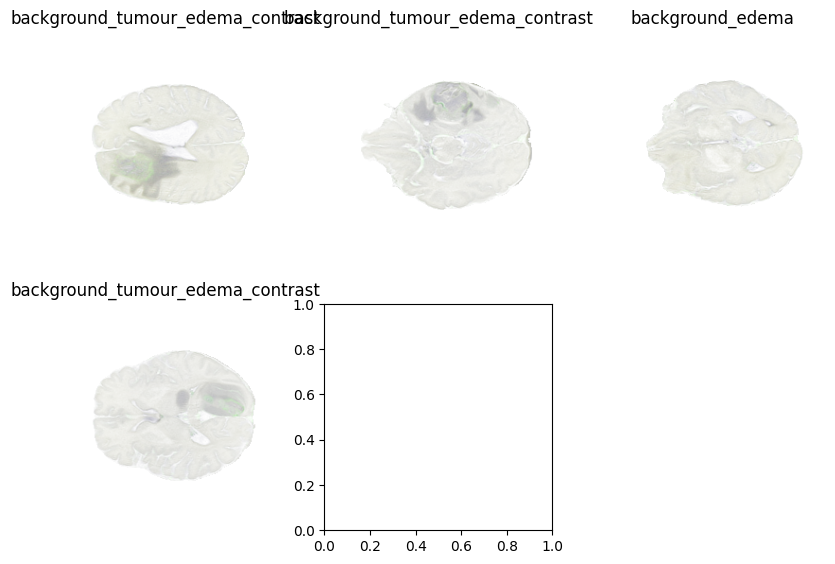

In [8]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [9]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(4, 240, 240, 4)
(4,)


In [17]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [18]:
normalization_layer = layers.Rescaling(1./(2**8-1))

In [19]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./(2**8-1), input_shape=(img_height, img_width, 4)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

In [ ]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [20]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  4)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)



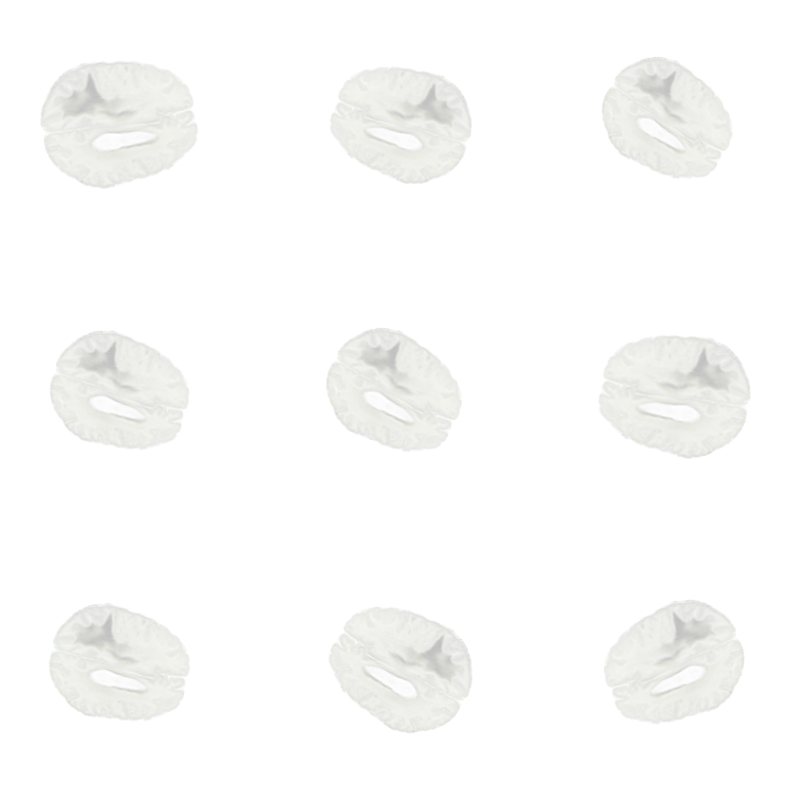

In [21]:

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    #with tf.device('/CPU:0'):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [22]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [23]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./(2**8-1)),
  layers.Conv2D(8, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dropout(0.2),
  layers.Dense(128, activation='relu'),
  layers.Dropout(0.2),
  layers.Dense(128, activation='relu'),
  layers.Dropout(0.2),
  layers.Dense(num_classes, name="outputs")
])

In [24]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [25]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 240, 240, 4)       0         
                                                                 
 rescaling_4 (Rescaling)     (None, 240, 240, 4)       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 240, 240, 8)       296       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 120, 120, 8)      0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 120, 120, 16)      1168      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 60, 60, 16)       0         
 2D)                                                  

In [26]:
epochs = 250
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/250


2022-11-21 10:55:04.538000: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


298/299 [============================>.] - ETA: 0s - loss: 1.1094 - accuracy: 0.4706

2022-11-21 10:55:15.162126: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


299/299 [==============================] - 12s 37ms/step - loss: 1.1095 - accuracy: 0.4707 - val_loss: 0.9567 - val_accuracy: 0.5671
Epoch 2/250
299/299 [==============================] - 11s 36ms/step - loss: 0.9769 - accuracy: 0.5637 - val_loss: 0.9408 - val_accuracy: 0.5705
Epoch 3/250
299/299 [==============================] - 10s 34ms/step - loss: 0.9535 - accuracy: 0.5670 - val_loss: 0.9652 - val_accuracy: 0.5537
Epoch 4/250
299/299 [==============================] - 11s 35ms/step - loss: 0.9350 - accuracy: 0.5720 - val_loss: 0.9211 - val_accuracy: 0.5973
Epoch 5/250
299/299 [==============================] - 10s 35ms/step - loss: 0.9316 - accuracy: 0.5896 - val_loss: 0.9440 - val_accuracy: 0.5503
Epoch 6/250
299/299 [==============================] - 10s 35ms/step - loss: 0.9308 - accuracy: 0.5704 - val_loss: 0.8969 - val_accuracy: 0.5839
Epoch 7/250
299/299 [==============================] - 10s 35ms/step - loss: 0.9245 - accuracy: 0.5762 - val_loss: 0.8974 - val_accuracy: 0.56

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
history